In [1]:
 import sys
sys.path.insert(0, '../../../network')
sys.path.insert(0, '../../../figures')
from sequences import GaussianSequence
from transfer_functions import ErrorFunction
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from learning import ReachingTask
import pandas as pd
from tqdm import tqdm, trange
import matplotlib
import matplotlib as mpl
from scipy import stats

In [13]:
filename = 'learning-env-40-0.0005-2000-0.6-04'
path = '/work/jp464/striatum-sequence/' + filename + '.npz'
data = np.load(path) 
overlaps_ctx = data['overlaps_ctx']
overlaps_d1 = data['overlaps_d1']
# overlaps_d2 = data['overlaps_d2']
# correlations_ctx = data['correlations_ctx']
# correlations_bg = data['correlations_bg']
state_ctx = data['state_ctx']
state_d1 = data['state_d1']

# Set font family globally
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
mpl.rcParams['axes.linewidth'] = 2

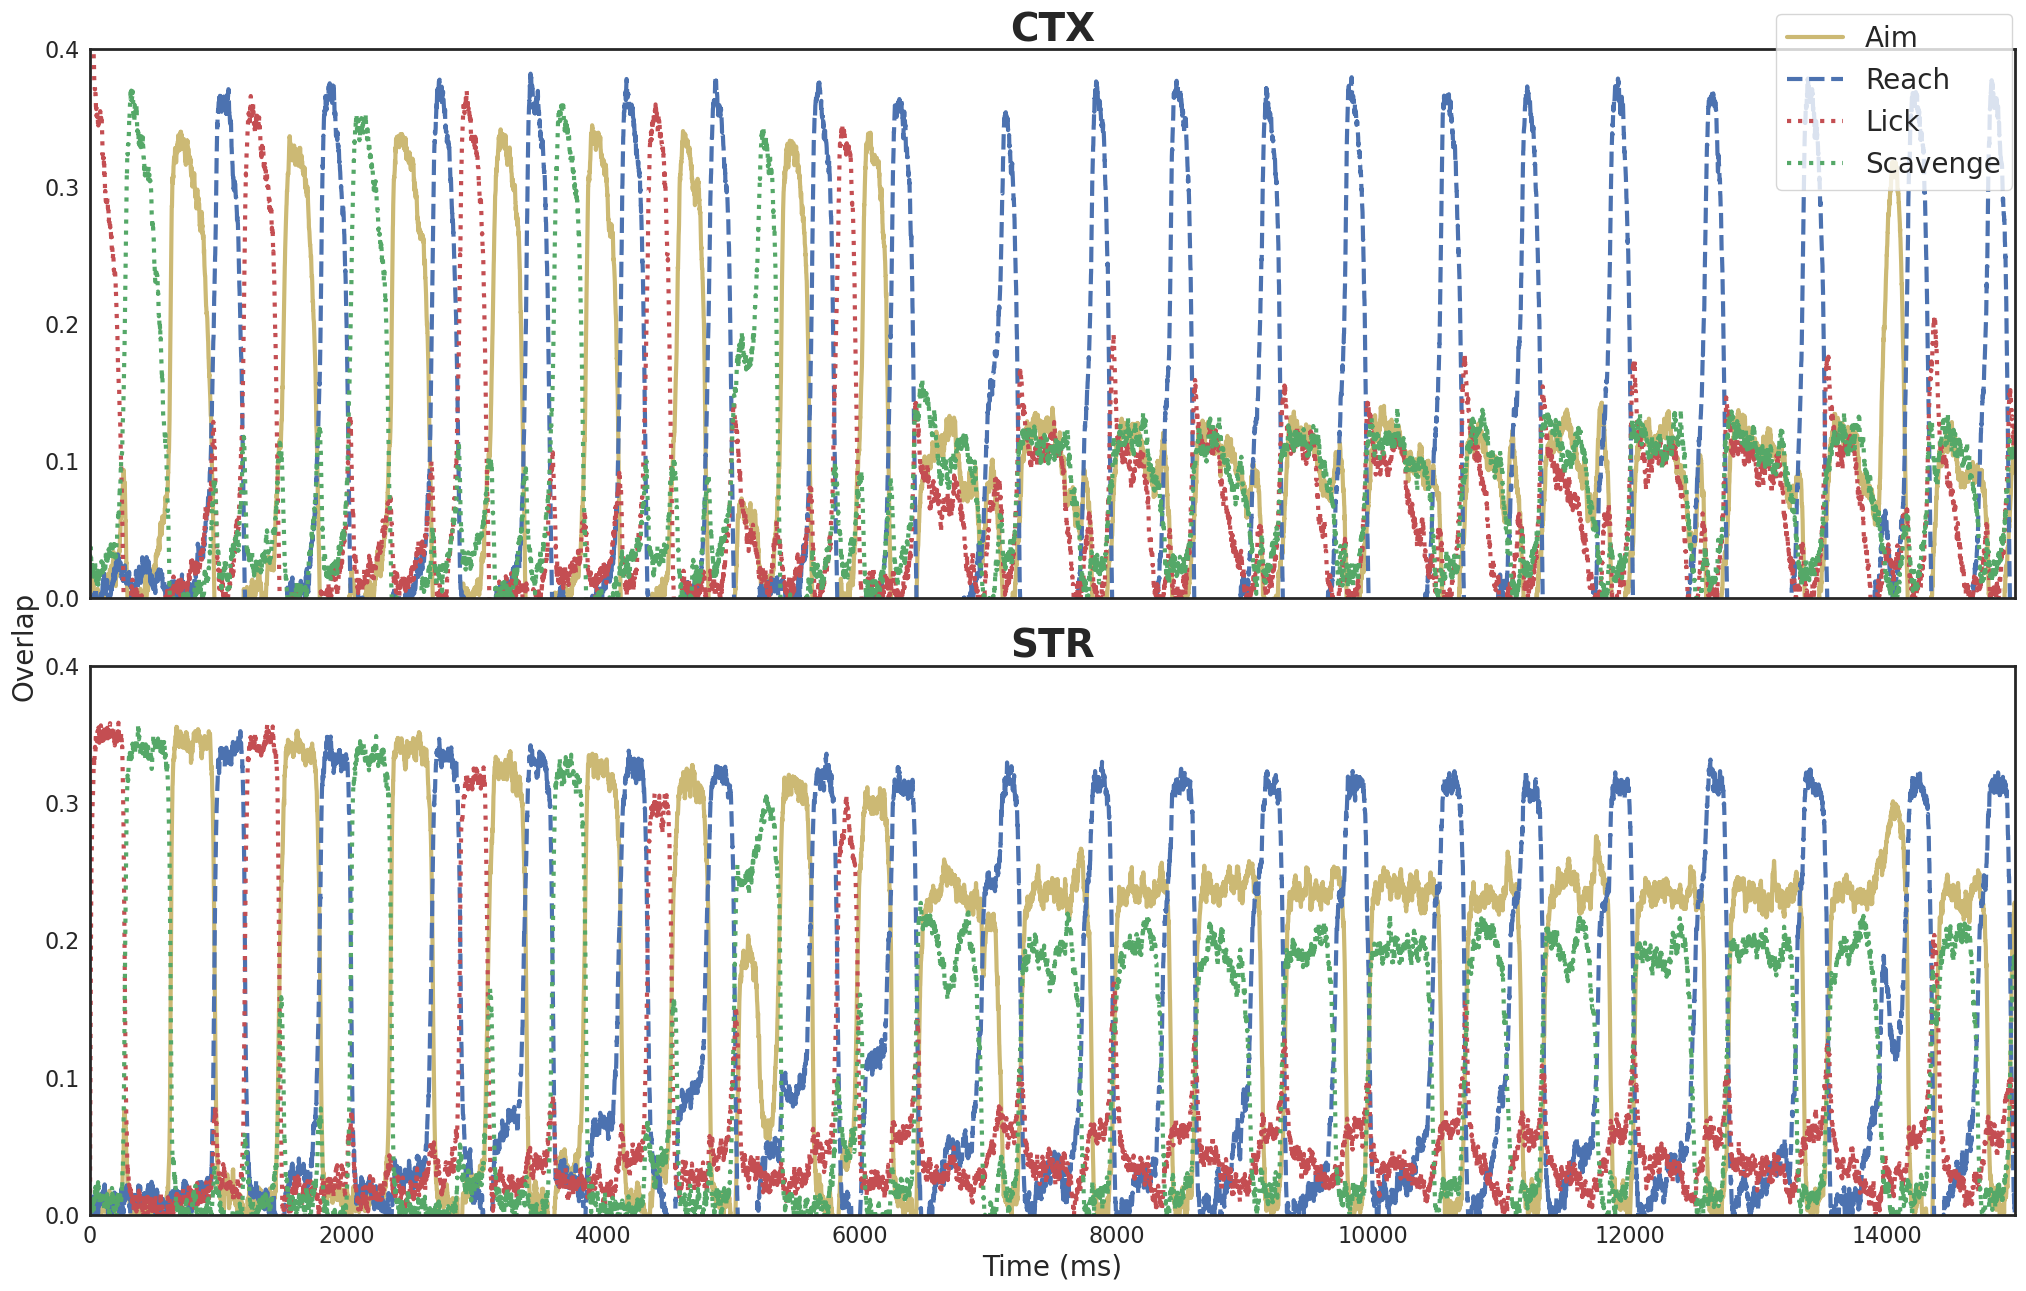

In [14]:
### Overlap 
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=28, weight='bold')
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("STR", fontsize=28, weight='bold')
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 15000), ylim=(0, 0.4))
plt.figlegend(labels=['Aim', 'Reach', 'Lick', 'Scavenge'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/learning2.jpg', bbox_inches = "tight", format='jpg')
plt.show()



In [6]:
state_d1 = data['state_d1']
state_d1[:,7000]


array([0.70469686, 0.30987691, 0.75798217, ..., 1.24366892, 1.04574801,
       0.97451865])